In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AE7lOrQ414aKsYRn32Bzs-0txPVQ7w9IEttqVFp-9Jsrpe4NRPCWkg
Mounted at /content/drive/


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications import VGG19
from keras.layers import GlobalMaxPooling2D
from keras import Model
from keras.applications.resnet50 import ResNet50
import time

%matplotlib inline

### unpack file

In [4]:
# tools

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

path = "/content/drive/My Drive/Colab Notebooks/code/"
file1 = unpickle(path + "data_batch_1")
file2 = unpickle(path + "data_batch_2")
file3 = unpickle(path + "data_batch_3")
file4 = unpickle(path + "data_batch_4")
file5 = unpickle(path + "data_batch_5")
file6 = unpickle(path + "test_batch")

def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 2) # set the vertical range to [0-2] 
    plt.show() 
    

### data processing
* normalization
* one hot
* separate training set into 2 parts, training set and validation set


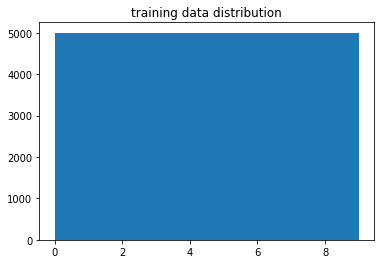

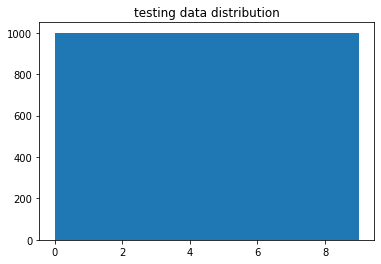

one hot sample [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
training data shape  (40000, 32, 32, 3) (40000, 10)
validation data shape  (10000, 32, 32, 3) (10000, 10)
testing data shape  (10000, 32, 32, 3) (10000, 10)


In [9]:
# data processing
# normalization
# one hot
# separate training set into 2 parts, training set and validation set

train_data_ori = np.r_[file1[b'data'],file2[b'data'],file3[b'data'],file4[b'data'],file5[b'data']]
train_label_ori = np.r_[file1[b'labels'],file2[b'labels'],file3[b'labels'],file4[b'labels'],file5[b'labels']]

test_data_ori = file6[b'data']
test_label_ori = np.r_[file6[b'labels']]

plt.hist(train_label_ori,bins=10)
plt.title("training data distribution")
plt.show()
plt.hist(test_label_ori,bins=10)
plt.title("testing data distribution")
plt.show()

train_data_ori = np.transpose(train_data_ori.reshape(-1, 3, 32, 32), (0, 2, 3, 1))
test_data_ori = np.transpose(test_data_ori.reshape(-1, 3, 32, 32), (0, 2, 3, 1))

train_data_ori = train_data_ori/255
test_data_ori = test_data_ori/255


# one hot
train_label_one_hot_ori = to_categorical(train_label_ori, 10)
test_label_one_hot = to_categorical(test_label_ori, 10)

print("one hot sample" , train_label_one_hot_ori[0])

# split the training set into training set and validation set
train_data, val_data, train_label, val_label = train_test_split(train_data_ori, train_label_one_hot_ori, train_size=0.8, random_state=42, stratify=train_label_one_hot_ori)
test_data, test_label = test_data_ori, test_label_one_hot

print("training data shape ", train_data.shape, train_label.shape)
print("validation data shape ", val_data.shape, val_label.shape)
print("testing data shape ", test_data.shape, test_label.shape)



## LeNet 5

### original form

Epoch 1/100
313/313 [==============================] - 4s 12ms/step - loss: 1.6302 - accuracy: 0.4039 - val_loss: 1.5145 - val_accuracy: 0.4686
Epoch 2/100
313/313 [==============================] - 3s 11ms/step - loss: 1.2832 - accuracy: 0.5388 - val_loss: 1.2098 - val_accuracy: 0.5759
Epoch 3/100
313/313 [==============================] - 3s 11ms/step - loss: 1.1246 - accuracy: 0.6018 - val_loss: 1.2516 - val_accuracy: 0.5632
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 1.0197 - accuracy: 0.6388 - val_loss: 1.0525 - val_accuracy: 0.6337
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 0.9389 - accuracy: 0.6675 - val_loss: 1.0420 - val_accuracy: 0.6393
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 0.8601 - accuracy: 0.6976 - val_loss: 0.9717 - val_accuracy: 0.6656
Epoch 7/100
313/313 [==============================] - 3s 11ms/step - loss: 0.7932 - accuracy: 0.7201 - val_loss: 0.9915 - val_accuracy:

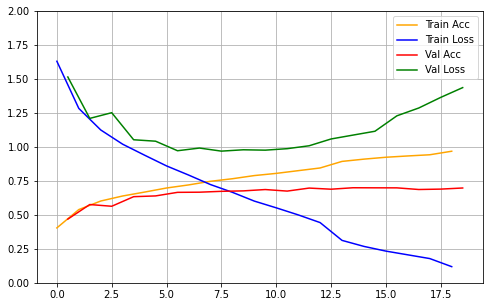

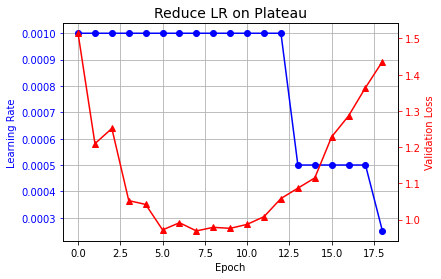

LeNet-5 architecture:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 48)        38448     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 48)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               442624    
_________________________________________________________________
dense_19 (Dense)             (No

In [19]:
def LeNet_model():
    model = keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(strides=2))
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(MaxPool2D(strides=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

leNet_model = LeNet_model()

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 100
batch_size = 128

tic = time.time()
LeNet_history = leNet_model.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
tok = time.time()
print((tok - tic)*1000 , "ms")

leNet_evaluation = leNet_model.evaluate(test_data, test_label)
leNet_test_acc = leNet_evaluation[1]
leNet_train_acc = np.max(LeNet_history.history['accuracy'])
leNet_val_acc = np.max(LeNet_history.history['val_accuracy'])
print("accuracy of the network on the training datasets is " , f'{leNet_train_acc * 100:.2f}%')
print("accuracy of the network on the validation datasets is " , f'{leNet_val_acc * 100:.2f}%')
print("accuracy of the network on the test datasets is ", f'{leNet_test_acc * 100:.2f}%')

plot_history(LeNet_history)

plt.plot(LeNet_history.epoch, LeNet_history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
#plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(LeNet_history.epoch, LeNet_history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

print("LeNet-5 architecture:")
leNet_model.summary()

### tuning key parameters with cross validation
* actfn=["elu", "relu"]
* optimizer=[keras.optimizers.Adam,keras.optimizers.SGD] 
* learningrate=[0.1,0.01,0.001,0.0001]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Epoch 1/100
209/209 [==============================] - 3s 13ms/step - loss: 1.7169 - accuracy: 0.3659 - val_loss: 1.6047 - val_accuracy: 0.4100
Epoch 2/100
209/209 [==============================] - 2s 12ms/step - loss: 1.3706 - accuracy: 0.5049 - val_loss: 1.3275 - val_accuracy: 0.5300
Epoch 3/100
209/209 [==============================] - 2s 12ms/step - loss: 1.2046 - accuracy: 0.5720 - val_loss: 1.1968 - val_accuracy: 0.5850
Epoch 4/100
209/209 [==============================] - 2s 12ms/step - loss: 1.0950 - accuracy: 0.6092 - val_loss: 1.1231 - val_accuracy: 0.6108
Epoch 5/100
209/209 [==============================] - 2s 12ms/step - loss: 1.0194 - accuracy: 0.6408 - val_loss: 1.0939 - val_accuracy: 0.6138
Epoch 6/100
209/209 [==============================] - 2s 11ms/step - loss: 0.9196 - accuracy: 0.6771 - val_loss: 1.1108 - val_accuracy: 0.6080
Epoch 7/100
209/209 [==============================] - 2s 12ms/step - loss: 0.8470 - accuracy: 0.7026 - val_loss: 1.0436 - val_accuracy:

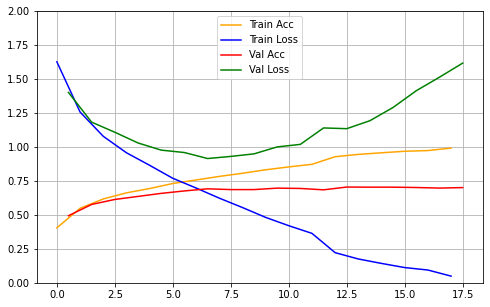

In [20]:
# Some key parameters
learningrate = 1   
batch_size = 128
n_epochs = 100

def model_leNet_factory(actfn="relu", optimizer=keras.optimizers.Adam, learningrate=0.001):
    # LeNet-5
    model = keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation=actfn, input_shape=(32, 32, 3)))
    model.add(MaxPool2D(strides=2))
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation=actfn))
    model.add(MaxPool2D(strides=2))
    model.add(Flatten())
    model.add(Dense(256, activation=actfn))
    model.add(Dense(84, activation=actfn))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr=learningrate), metrics=['accuracy'])
    return model

def randomSearch_LeNet(model):
    keras_cls = keras.wrappers.scikit_learn.KerasClassifier(model)

    param_distribs = {
        "actfn": ["elu","relu",],
        "optimizer": [keras.optimizers.Adam, keras.optimizers.SGD],
        "learningrate": [0.0001*learningrate, 0.001*learningrate, 0.01*learningrate, 0.1*learningrate],
    }

    timeBeforeTraining = time.time()
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    rnd_search_cv_dnn = RandomizedSearchCV(keras_cls, param_distribs, n_iter=10, cv=3)
    rnd_search_cv_dnn.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
    timeAfterTraining = time.time()
    print("the training last ", np.round(timeAfterTraining - timeBeforeTraining, 3), " seconds")

    return rnd_search_cv_dnn

model_LeNet_with_para = randomSearch_LeNet(model_leNet_factory)

print("best parameter is ", model_LeNet_with_para.best_params_)
print("best score is ", model_LeNet_with_para.best_score_)
model_LeNet_with_para_history = model_LeNet_with_para.best_estimator_.model.history
plot_history(model_LeNet_with_para_history)

### best parameter is  {'optimizer': 'Adam', 'learningrate': 0.001, 'actfn': 'relu'}
### best score is  0.6737750172615051
### valadation accuracy is 0.56, training accuracy is 1, it is overfit, we need to drop some parts to deal with overfit, and a drop out layer after the first max pooling layer

Epoch 1/100
313/313 [==============================] - 4s 13ms/step - loss: 1.7125 - accuracy: 0.3708 - val_loss: 1.4119 - val_accuracy: 0.4997
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 1.3300 - accuracy: 0.5221 - val_loss: 1.3086 - val_accuracy: 0.5272
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 1.1936 - accuracy: 0.5735 - val_loss: 1.1554 - val_accuracy: 0.5917
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 1.0909 - accuracy: 0.6137 - val_loss: 1.0797 - val_accuracy: 0.6212
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 1.0061 - accuracy: 0.6439 - val_loss: 1.0135 - val_accuracy: 0.6476
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 0.9522 - accuracy: 0.6653 - val_loss: 0.9836 - val_accuracy: 0.6558
Epoch 7/100
313/313 [==============================] - 4s 11ms/step - loss: 0.8901 - accuracy: 0.6837 - val_loss: 0.9586 - val_accuracy:

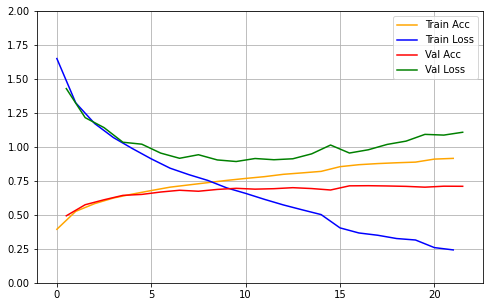

In [28]:
def model_leNet_drop_factory():
    # LeNet-5
    learningrate=0.001
    actfn = "relu"
    optimizer = keras.optimizers.Adam

    model = keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(MaxPool2D(strides=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr=learningrate), metrics=['accuracy'])
    return model

leNet_model_drop = model_leNet_drop_factory()

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 100
batch_size = 128
tic = time.time()
LeNet_drop_history = leNet_model_drop.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
tok = time.time()
print((tok - tic)*1000 , "ms")

leNet_drop_evaluation = leNet_model_drop.evaluate(test_data, test_label)
leNet_drop_train_acc = np.max(LeNet_drop_history.history['accuracy'])
leNet_drop_val_acc = np.max(LeNet_drop_history.history['val_accuracy'])
leNet_drop_test_acc = leNet_drop_evaluation[1]
print("training datasets accuracy is " , f'{leNet_drop_train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{leNet_drop_val_acc * 100:.2f}%')
plot_history(history)


Epoch 1/100
313/313 [==============================] - 4s 13ms/step - loss: 1.7749 - accuracy: 0.3448 - val_loss: 1.5112 - val_accuracy: 0.4687
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 1.4344 - accuracy: 0.4788 - val_loss: 1.3098 - val_accuracy: 0.5349
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 1.3150 - accuracy: 0.5262 - val_loss: 1.2432 - val_accuracy: 0.5742
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 1.2155 - accuracy: 0.5631 - val_loss: 1.1373 - val_accuracy: 0.6055
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 1.1549 - accuracy: 0.5874 - val_loss: 1.0594 - val_accuracy: 0.6408
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 1.0841 - accuracy: 0.6129 - val_loss: 1.0053 - val_accuracy: 0.6492
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 1.0431 - accuracy: 0.6316 - val_loss: 1.0021 - val_accuracy:

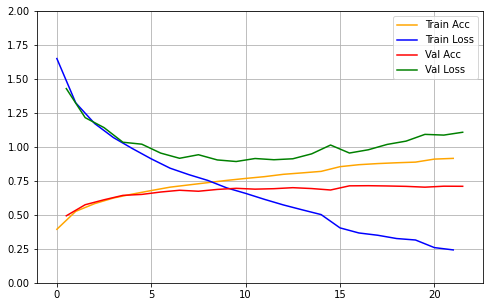

In [29]:
def model_leNet_drop_factory():
    # LeNet-5
    learningrate=0.001
    actfn = "relu"
    optimizer = keras.optimizers.Adam

    model = keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr=learningrate), metrics=['accuracy'])
    return model

leNet_model_drop = model_leNet_drop_factory()

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 100
batch_size = 128
tic = time.time()
LeNet_drop_history = leNet_model_drop.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
tok = time.time()
print((tok - tic)*1000 , "ms")

leNet_drop_train_acc = np.max(LeNet_drop_history.history['accuracy'])
leNet_drop_val_acc = np.max(LeNet_drop_history.history['val_accuracy'])
print("training datasets accuracy is " , f'{leNet_drop_train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{leNet_drop_val_acc * 100:.2f}%')
plot_history(history)



#### but the score is too low, we have some options to make the architecture more flexible to increase the accuracy.
1. increase convolutional layer filters
2. add dense layer units
3. add more layers
4. BatchNormalization before every Convolutional Layer.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Epoch 1/100
834/834 [==============================] - 7s 9ms/step - loss: 1.7893 - accuracy: 0.3353 - val_loss: 1.5606 - val_accuracy: 0.4593
Epoch 2/100
834/834 [==============================] - 7s 8ms/step - loss: 1.5085 - accuracy: 0.4478 - val_loss: 1.5300 - val_accuracy: 0.4587
Epoch 3/100
834/834 [==============================] - 7s 8ms/step - loss: 1.4003 - accuracy: 0.4936 - val_loss: 1.2814 - val_accuracy: 0.5496
Epoch 4/100
834/834 [==============================] - 7s 8ms/step - loss: 1.3294 - accuracy: 0.5188 - val_loss: 1.2448 - val_accuracy: 0.5647
Epoch 5/100
834/834 [==============================] - 7s 8ms/step - loss: 1.2771 - accuracy: 0.5417 - val_loss: 1.1803 - val_accuracy: 0.5893
Epoch 6/100
834/834 [==============================] - 7s 8ms/step - loss: 1.2271 - accuracy: 0.5601 - val_loss: 1.2069 - val_accuracy: 0.5798
Epoch 7/100
834/834 [==============================] - 7s 8ms/step - loss: 1.1857 - accuracy: 0.5713 - val_loss: 1.1568 - val_accuracy: 0.5953

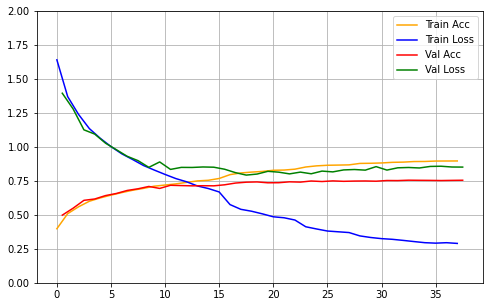

In [31]:
# 1, increase convolutional layer filters
# 2, add dense layer units

def model_leNet_size_factory(filter_size=1, dense_units_size=1):
    # LeNet-5
    learningrate=0.001
    actfn = "relu"
    optimizer = keras.optimizers.Adam

    model = keras.Sequential()
    model.add(layers.Conv2D(filters=32*filter_size, kernel_size=(5, 5), activation=actfn, input_shape=(32,32,3)))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(layers.Conv2D(filters=48*filter_size, kernel_size=(5, 5), activation=actfn))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256*dense_units_size, activation=actfn))
    model.add(layers.Dense(units=84*dense_units_size, activation=actfn))
    model.add(layers.Dense(units=10, activation = 'softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

def randomSearch_LeNet_size(model):
    keras_cls = keras.wrappers.scikit_learn.KerasClassifier(model)

    param_distribs = {
        "filter_size": range(1,4),
        "dense_units_size": range(1,4)
        }

    timeBeforeTraining = time.time()
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    n_epochs = 100
    
    rnd_search_cv_dnn = RandomizedSearchCV(keras_cls, param_distribs, n_iter=10, cv=3)
    rnd_search_cv_dnn.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label), callbacks=[early_stopping_cb, lr_scheduler])
    timeAfterTraining = time.time()
    print("the training last ", np.round(timeAfterTraining - timeBeforeTraining, 3), " seconds")

    return rnd_search_cv_dnn


model_LeNet_with_size = randomSearch_LeNet_size(model_leNet_size_factory)

print("best parameter is ", model_LeNet_with_size.best_params_)
print("best score is ", model_LeNet_with_size.best_score_)
model_LeNet_with_size_history = model_LeNet_with_size.best_estimator_.model.history
plot_history(model_LeNet_with_size_history)

Epoch 1/100
313/313 [==============================] - 8s 27ms/step - loss: 1.6805 - accuracy: 0.3798 - val_loss: 1.4433 - val_accuracy: 0.4826
Epoch 2/100
313/313 [==============================] - 8s 26ms/step - loss: 1.3521 - accuracy: 0.5137 - val_loss: 1.1901 - val_accuracy: 0.5778
Epoch 3/100
313/313 [==============================] - 8s 26ms/step - loss: 1.2281 - accuracy: 0.5612 - val_loss: 1.1246 - val_accuracy: 0.6187
Epoch 4/100
313/313 [==============================] - 8s 26ms/step - loss: 1.1231 - accuracy: 0.6025 - val_loss: 1.0421 - val_accuracy: 0.6427
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 1.0422 - accuracy: 0.6319 - val_loss: 0.9919 - val_accuracy: 0.6536
Epoch 6/100
313/313 [==============================] - 8s 26ms/step - loss: 0.9692 - accuracy: 0.6586 - val_loss: 1.0120 - val_accuracy: 0.6610
Epoch 7/100
313/313 [==============================] - 8s 26ms/step - loss: 0.9114 - accuracy: 0.6783 - val_loss: 0.8901 - val_accuracy:

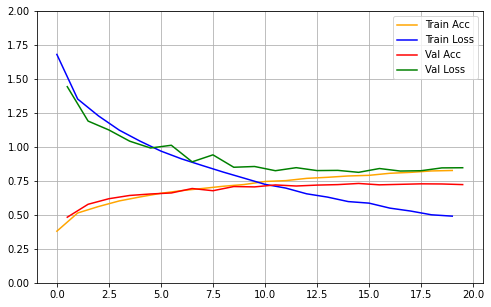

In [32]:
def model_leNet_size_factory(filter_size=3, dense_units_size=2):
    # LeNet-5
    learningrate=0.001
    actfn = "relu"
    optimizer = keras.optimizers.Adam

    model = keras.Sequential()
    model.add(layers.Conv2D(filters=32*filter_size, kernel_size=(5, 5), activation=actfn, input_shape=(32,32,3)))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(layers.Conv2D(filters=48*filter_size, kernel_size=(5, 5), activation=actfn))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256*dense_units_size, activation=actfn))
    model.add(layers.Dense(units=84*dense_units_size, activation=actfn))
    model.add(layers.Dense(units=10, activation = 'softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

leNet_model_size = model_leNet_size_factory()

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 100
batch_size = 128
tic = time.time()
LeNet_size_history = leNet_model_size.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
tok = time.time()
print((tok - tic)*1000 , "ms")

leNet_size_train_acc = np.max(LeNet_size_history.history['accuracy'])
leNet_size_val_acc = np.max(LeNet_size_history.history['val_accuracy'])
print("training datasets accuracy is " , f'{leNet_size_train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{leNet_size_val_acc * 100:.2f}%')
plot_history(LeNet_size_history)




Epoch 1/100
313/313 [==============================] - 19s 61ms/step - loss: 1.6441 - accuracy: 0.4005 - val_loss: 1.8469 - val_accuracy: 0.3541
Epoch 2/100
313/313 [==============================] - 18s 59ms/step - loss: 1.2439 - accuracy: 0.5542 - val_loss: 1.0965 - val_accuracy: 0.6088
Epoch 3/100
313/313 [==============================] - 18s 58ms/step - loss: 1.0524 - accuracy: 0.6313 - val_loss: 0.9804 - val_accuracy: 0.6575
Epoch 4/100
313/313 [==============================] - 18s 58ms/step - loss: 0.9179 - accuracy: 0.6770 - val_loss: 0.9304 - val_accuracy: 0.6801
Epoch 5/100
313/313 [==============================] - 18s 58ms/step - loss: 0.8242 - accuracy: 0.7121 - val_loss: 0.8071 - val_accuracy: 0.7220
Epoch 6/100
313/313 [==============================] - 18s 58ms/step - loss: 0.7470 - accuracy: 0.7410 - val_loss: 0.7856 - val_accuracy: 0.7333
Epoch 7/100
313/313 [==============================] - 18s 58ms/step - loss: 0.6900 - accuracy: 0.7590 - val_loss: 0.7522 - val_ac

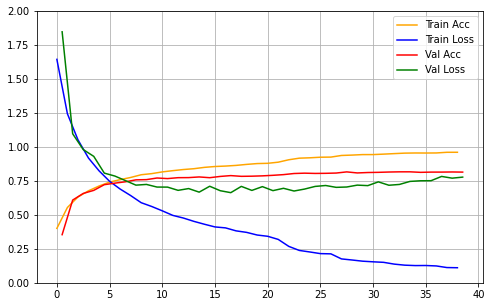

In [33]:
# 3, add more layers
# 4, BatchNormalization before every Convolutional Layer.

def model_leNet_layer_factory():
    # LeNet-5
    learningrate=0.001
    actfn = "relu"
    optimizer = keras.optimizers.Adam
    filter_size = 3
    dense_units_size = 2

    model = keras.Sequential()
    model.add(BatchNormalization())
    model.add(layers.Conv2D(filters=32*filter_size, kernel_size=(5, 5), activation=actfn, input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(filters=32*filter_size, kernel_size=(5, 5), activation=actfn, input_shape=(32,32,3)))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(filters=48*filter_size, kernel_size=(5, 5), activation=actfn))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(filters=48*filter_size, kernel_size=(5, 5), activation=actfn))
    model.add(MaxPool2D(strides=2))
    model.add(keras.layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256*dense_units_size, activation=actfn))
    model.add(layers.Dense(units=84*dense_units_size, activation=actfn))
    model.add(layers.Dense(units=10, activation = 'softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model


leNet_model_layer = model_leNet_layer_factory()

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 100
batch_size = 128
tic = time.time()
LeNet_layer_history = leNet_model_layer.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
tok = time.time()
print((tok - tic)*1000 , "ms")

leNet_layer_train_acc = np.max(LeNet_layer_history.history['accuracy'])
leNet_layer_val_acc = np.max(LeNet_layer_history.history['val_accuracy'])
print("training datasets accuracy is " , f'{leNet_layer_train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{leNet_layer_val_acc * 100:.2f}%')
plot_history(LeNet_layer_history)


In [ ]:
# modified LeNet-5 perform good

In [36]:
leNet_layer_evaluation = leNet_model_layer.evaluate(test_data, test_label)
leNet_layer_test_acc = leNet_layer_evaluation[1]
print("test datasets accuracy is " , f'{leNet_layer_test_acc * 100:.2f}%')


313/313 [==============================] - 2s 8ms/step - loss: 0.7437 - accuracy: 0.8162
test datasets accuracy is  81.62%


### modified VGG
#### we have decrease the dense units and delete a set of convolutional layers and a maximum pool layer due to the small image size

Epoch 1/100
313/313 [==============================] - 17s 54ms/step - loss: 1.7375 - accuracy: 0.4168 - val_loss: 2.2052 - val_accuracy: 0.2433
Epoch 2/100
313/313 [==============================] - 16s 52ms/step - loss: 1.0975 - accuracy: 0.6060 - val_loss: 0.9648 - val_accuracy: 0.6575
Epoch 3/100
313/313 [==============================] - 16s 52ms/step - loss: 0.8443 - accuracy: 0.7008 - val_loss: 0.7679 - val_accuracy: 0.7239
Epoch 4/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6965 - accuracy: 0.7545 - val_loss: 0.7395 - val_accuracy: 0.7439
Epoch 5/100
313/313 [==============================] - 16s 52ms/step - loss: 0.5829 - accuracy: 0.7940 - val_loss: 0.7245 - val_accuracy: 0.7552
Epoch 6/100
313/313 [==============================] - 16s 52ms/step - loss: 0.4959 - accuracy: 0.8231 - val_loss: 0.6674 - val_accuracy: 0.7778
Epoch 7/100
313/313 [==============================] - 16s 52ms/step - loss: 0.4133 - accuracy: 0.8542 - val_loss: 0.6789 - val_ac

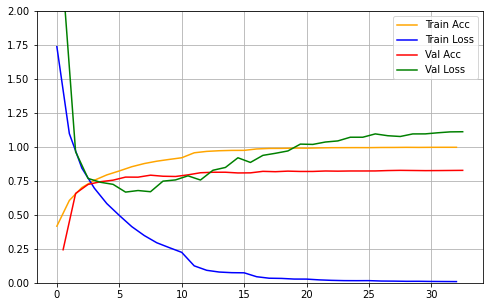

In [37]:
def model_VGG_factory():

    model = Sequential()

    # Convolutional Layer
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    """
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    """

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

VGG_model = model_VGG_factory()
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 100
batch_size = 128
tic = time.time()
VGG_history = VGG_model.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
tok = time.time()
print((tok - tic)*1000 , "ms")

VGG_train_acc = np.max(VGG_history.history['accuracy'])
VGG_val_acc = np.max(VGG_history.history['val_accuracy'])
print("training datasets accuracy is " , f'{VGG_train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{VGG_val_acc * 100:.2f}%')
plot_history(VGG_history)


### AlexNet
#### we have decrease the pool size and delete a maximum pool layer due to the small image size

Epoch 1/100
313/313 [==============================] - 10s 32ms/step - loss: 1.8023 - accuracy: 0.3507 - val_loss: 3.3021 - val_accuracy: 0.1487
Epoch 2/100
313/313 [==============================] - 9s 29ms/step - loss: 1.6178 - accuracy: 0.4199 - val_loss: 2.2229 - val_accuracy: 0.2929
Epoch 3/100
313/313 [==============================] - 9s 30ms/step - loss: 1.5283 - accuracy: 0.4570 - val_loss: 2.1180 - val_accuracy: 0.3210
Epoch 4/100
313/313 [==============================] - 9s 29ms/step - loss: 1.4892 - accuracy: 0.4716 - val_loss: 1.6630 - val_accuracy: 0.4125
Epoch 5/100
313/313 [==============================] - 9s 30ms/step - loss: 1.4391 - accuracy: 0.4948 - val_loss: 1.5377 - val_accuracy: 0.4568
Epoch 6/100
313/313 [==============================] - 9s 30ms/step - loss: 1.3895 - accuracy: 0.5138 - val_loss: 1.5930 - val_accuracy: 0.4422
Epoch 7/100
313/313 [==============================] - 9s 29ms/step - loss: 1.3538 - accuracy: 0.5307 - val_loss: 1.5170 - val_accuracy

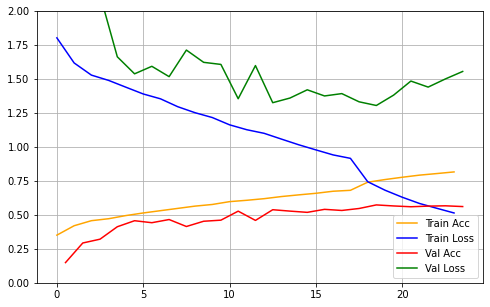

In [39]:
AlexNet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(32,32,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
AlexNet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])   


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 100
batch_size = 128
tic = time.time()
AlexNet_history = AlexNet_model.fit(train_data, train_label, epochs=n_epochs, validation_data=(val_data, val_label),batch_size=batch_size, callbacks=[early_stopping_cb, lr_scheduler])
tok = time.time()
print((tok - tic)*1000 , "ms")

AlexNet_train_acc = np.max(AlexNet_history.history['accuracy'])
AlexNet_val_acc = np.max(AlexNet_history.history['val_accuracy'])
print("training datasets accuracy is " , f'{AlexNet_train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{AlexNet_val_acc * 100:.2f}%')
plot_history(AlexNet_history)


### ResNet 50

In [42]:
# ResNet50
base_model = ResNet50(include_top=False,input_shape=(32,32,3))

x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(10, activation="softmax")(x)
base_model = Model(base_model.input, x, name="base_model")
base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer="adam")
base_model.summary()


94773248/94765736 [==============================] - 2s 0us/step
Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
________________________

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True) 
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

tic = time.time()
history = base_model.fit(train_data, train_label, epochs=100, validation_data=(val_data, val_label),batch_size=512, callbacks=[early_stopping_cb, lr_scheduler])

tok = time.time()
print((tok - tic)*1000 , "ms")

evaluation = base_model.evaluate(test_data, test_label)
train_acc = np.max(history.history['accuracy'])
val_acc = np.max(history.history['val_accuracy'])
test_acc = evaluation[1]
print("training datasets accuracy is " , f'{train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{val_acc * 100:.2f}%')
print("test datasets accuracy is " , f'{test_acc * 100:.2f}%')


Epoch 1/100
79/79 [==============================] - 33s 413ms/step - loss: 0.2876 - acc: 0.2432 - val_loss: 0.3322 - val_acc: 0.0970
Epoch 2/100
79/79 [==============================] - 33s 412ms/step - loss: 0.2762 - acc: 0.2783 - val_loss: 0.3317 - val_acc: 0.0901
Epoch 3/100
79/79 [==============================] - 33s 413ms/step - loss: 0.2659 - acc: 0.3103 - val_loss: 0.3289 - val_acc: 0.1340
Epoch 4/100
79/79 [==============================] - 33s 413ms/step - loss: 0.2522 - acc: 0.3600 - val_loss: 0.3329 - val_acc: 0.1669
Epoch 5/100
79/79 [==============================] - 33s 414ms/step - loss: 0.2305 - acc: 0.4453 - val_loss: 0.3238 - val_acc: 0.2221
Epoch 6/100
79/79 [==============================] - 33s 413ms/step - loss: 0.2077 - acc: 0.5248 - val_loss: 0.3100 - val_acc: 0.2783
Epoch 7/100
79/79 [==============================] - 33s 413ms/step - loss: 0.1873 - acc: 0.5856 - val_loss: 0.3086 - val_acc: 0.3864
Epoch 8/100
79/79 [==============================] - 33s 413ms

### Xception
#### Input size must be at least 71x71

In [ ]:


# Xception

from keras.applications import Xception
from keras.layers import GlobalMaxPooling2D
from keras import Model

base_model = Xception(include_top=False,input_shape=(32,32,3))

base_model.summary()

ValueError: ignored

### original VGG 16

In [ ]:
base_model = VGG16(include_top=False,input_shape=(32,32,3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dense(10, activation="softmax")(x)
base_model = Model(base_model.input, x, name="base_model")
base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer="adam")

base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________

In [ ]:

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True) 
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

tic = time.time()
history = base_model.fit(train_data, train_label, epochs=100, validation_data=(val_data, val_label),batch_size=128, callbacks=[early_stopping_cb, lr_scheduler])

tok = time.time()
print((tok - tic)*1000 , "ms")

evaluation = base_model.evaluate(test_data, test_label)
train_acc = np.max(history.history['accuracy'])
val_acc = np.max(history.history['val_accuracy'])
test_acc = evaluation[1]
print("training datasets accuracy is " , f'{train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{val_acc * 100:.2f}%')
print("test datasets accuracy is " , f'{test_acc * 100:.2f}%')


Epoch 1/100
313/313 [==============================] - 12s 39ms/step - loss: 0.3283 - acc: 0.0995 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3251 - acc: 0.0969 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3251 - acc: 0.0975 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3251 - acc: 0.0979 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3251 - acc: 0.0985 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 6/100
313/313 [==============================] - 12s 37ms/step - loss: 0.3251 - acc: 0.0960 - val_loss: 0.3251 - val_acc: 0.1000
78328.14764976501 ms


### original VGG19

In [ ]:
base_model = VGG19(include_top=False,input_shape=(32,32,3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dense(10, activation="softmax")(x)
base_model = Model(base_model.input, x, name="base_model")
base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer="adam")

base_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True) 
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

tic = time.time()
history = base_model.fit(train_data, train_label, epochs=100, validation_data=(val_data, val_label),batch_size=128, callbacks=[early_stopping_cb, lr_scheduler])

tok = time.time()
print((tok - tic)*1000 , "ms")

evaluation = base_model.evaluate(test_data, test_label)
train_acc = np.max(history.history['accuracy'])
val_acc = np.max(history.history['val_accuracy'])
test_acc = evaluation[1]
print("training datasets accuracy is " , f'{train_acc * 100:.2f}%')
print("validation datasets accuracy is " , f'{val_acc * 100:.2f}%')
print("test datasets accuracy is " , f'{test_acc * 100:.2f}%')


Epoch 1/100
313/313 [==============================] - 15s 47ms/step - loss: 0.3289 - acc: 0.0976 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.3251 - acc: 0.0994 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 0.3251 - acc: 0.0967 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 4/100
313/313 [==============================] - 14s 45ms/step - loss: 0.3251 - acc: 0.0972 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.3251 - acc: 0.1000 - val_loss: 0.3251 - val_acc: 0.1000
Epoch 6/100
313/313 [==============================] - 14s 45ms/step - loss: 0.3251 - acc: 0.0969 - val_loss: 0.3251 - val_acc: 0.1000
86470.19672393799 ms
